# STEP 0. 필요 라이브러리 import

In [22]:
import os
from konlpy.tag import Okt
okt = Okt()
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from numpy import dot
from numpy.linalg import norm
import seaborn as sns
import matplotlib.pyplot as plt

# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출

In [3]:
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

# STEP 2. 추출된 결과로 embedding model 생성

In [4]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

In [5]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.8864167928695679),
 ('다큐멘터리', 0.856126070022583),
 ('드라마', 0.812335729598999),
 ('영화로', 0.7941468358039856),
 ('주제', 0.7840924263000488),
 ('형식', 0.7794634699821472),
 ('실화', 0.7734053730964661),
 ('소재', 0.7719899415969849),
 ('설정', 0.7700799703598022),
 ('개연', 0.7600735425949097)]

In [6]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7110268473625183),
 ('애정', 0.6934056878089905),
 ('연애', 0.6916449666023254),
 ('진심', 0.6891140341758728),
 ('첫사랑', 0.68500816822052),
 ('열정', 0.6844486594200134),
 ('가슴', 0.6774987578392029),
 ('고백', 0.6689162850379944),
 ('만남', 0.6680919528007507),
 ('감정', 0.6673418879508972)]

In [7]:
model.wv.most_similar(positive=['증오'])

[('분노', 0.9241383075714111),
 ('불신', 0.9057050347328186),
 ('연민', 0.9029797315597534),
 ('가중', 0.8993649482727051),
 ('트라우마', 0.882538914680481),
 ('죄책감', 0.8792699575424194),
 ('회복', 0.8780287504196167),
 ('신뢰', 0.869886040687561),
 ('부정', 0.8689050674438477),
 ('벌초', 0.868838369846344)]

# STEP 3. target, attribute 단어 셋 생성

명사 추출하는 메서드 정의

In [9]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

target 단어셋 생성

In [10]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다.

n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


attribute 단어셋 생성

- snen_words라는 집합(set)을 만들어서 중복 단어가 발생하지 않도록 관리
    - 단어가 처음 등장할 때만 attr에 추가하고, 그 이후에는 무시

In [11]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

# 중복 단어를 추적할 set 생성
seen_words = set()

# 상위 15개의 단어 추출
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while len(attr) < 15:
        word = vectorizer.get_feature_names_out()[w[i][j][0]]
        
        # Word2Vec 모델 사전에 존재하고, 중복되지 않는 단어만 추가
        if word in model.wv and word not in seen_words:
            attr.append(word)
            seen_words.add(word)  # 중복 방지를 위해 추가된 단어는 seen_words에 기록
            print(word, end=', ')
        j += 1
    attributes.append(attr)
    print()

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
SF: 백업, 공공, 탑승객, 패닉, 동태, 동요, 한정, 물살, 조단, 공대생, 식기, 알러지, 천식, 로베르토, 샌드라, 
가족: 파울, 막스, 리케, 악동, 어벤져스, 연령, 반려동물, 최선, 신제품, 선정, 평균, 소비자, 볼러스, 배려, 행복감, 
공연: 아키노, 멘토, 레너드, 브람스, 요하네스, 서곡, 판타지아, 마무리, 야외, 하모니, 교향곡, 아낙네, 니콜라이, 피에르, 메타, 
공포(호러): 유포, 는걸, 성행위, 목덜미, 교환학생, 담요, 음식점, 금발, 허기, 사우스, 실감, 용진, 영호, 호진, 몬세, 
기타

# STEP 4. WEAT score 계산과 시각화

WEAT score 계산

In [12]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [16]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [19]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [20]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 0.40916762
SF 공연 -0.04393486
SF 공포(호러) -0.9121653
SF 기타 -0.94232446
SF 다큐멘터리 0.4519706
SF 드라마 -0.79373705
SF 멜로로맨스 -0.78315556
SF 뮤지컬 -0.3944253
SF 미스터리 0.21122146
SF 범죄 -0.5020833
SF 사극 -0.05129551
SF 서부극(웨스턴) 0.018777255
SF 성인물(에로) -0.5942815
SF 스릴러 -0.04529676
SF 애니메이션 -0.7212682
SF 액션 -0.2283425
SF 어드벤처 -0.15544714
SF 전쟁 0.77294916
SF 코미디 0.14495315
SF 판타지 -0.3784852
가족 공연 -0.7008439
가족 공포(호러) -0.976556
가족 기타 -0.89454705
가족 다큐멘터리 0.23575158
가족 드라마 -0.74821436
가족 멜로로맨스 -0.6875971
가족 뮤지컬 -0.671064
가족 미스터리 -0.18057579
가족 범죄 -0.52570015
가족 사극 -0.3633818
가족 서부극(웨스턴) -0.30214235
가족 성인물(에로) -0.67342293
가족 스릴러 -0.27512586
가족 애니메이션 -0.8358756
가족 액션 -0.34243113
가족 어드벤처 -0.42661184
가족 전쟁 0.48142356
가족 코미디 -0.25267288
가족 판타지 -0.51475114
공연 공포(호러) -0.8789147
공연 기타 -0.5691344
공연 다큐멘터리 0.7168103
공연 드라마 -0.47738665
공연 멜로로맨스 -0.50060415
공연 뮤지컬 -0.381485
공연 미스터리 0.23721682
공연 범죄 -0.30877212
공연 사극 0.0018696608
공연 서부극(웨스턴) 0.05142209
공연 성인물(에로) -0.53904444
공연 스릴러 -0.0031663768
공연 애니메이션 -0.441825

**요약 v.chatGPT**

**SF (공상과학)**:

- **SF-전쟁**은 0.772로 상업영화와 더 연관성이 있음
    - 반면, **SF-멜로로맨스**(-0.783), **SF-공포(호러)**(-0.912) 등은 예술영화에 더 가까운 경향이 있음

---

**가족**:

- **가족-다큐멘터리**(0.235)는 상업영화에 가까우나, 대부분의 장르에서 음수 점수를 보여 예술영화에 더 가까운 편임
    - 예를 들어 **가족-공포(호러)**(-0.976)는 아주 강하게 예술영화와 연관됨

---

**공연**:
- **공연-전쟁**(0.799), **공연-코미디**(0.277)는 상업영화에 가까운 경향을 보임
    - 공연은 다른 장르와의 관계에서는 대체로 편향이 적음
    
---

**공포(호러)**:
- **공포(호러)-전쟁**(1.054)와 같이 상업영화에 더 가까운 강한 편향이 보이기도 함 
    - 대부분은 예술영화와 강한 연관성이 있음 (**공포-다큐멘터리**(0.948)는 상업영화와 연관)

---

**기타**:
- **기타-다큐멘터리**(0.782), **기타-전쟁**(0.934) 등에서 상업영화와 강한 연관성을 보임

---

**다큐멘터리**:
- 다큐멘터리는 대부분 예술영화와 강한 관계를 나타내고 있음
    - 예를 들어 **다큐멘터리-드라마**(-0.771), **다큐멘터리-멜로로맨스**(-0.726) 등의 관계는 예술영화와의 강한 연관성을 보여줌

---

**드라마**:
- **드라마-전쟁**(1.057), **드라마-코미디**(0.680)처럼 상업영화와 가까운 성향을 가짐
    - 나머지 대부분의 장르에 대해서는 예술영화와 연관됨

---

**멜로로맨스**:
- **멜로로맨스-전쟁**(0.980), **멜로로맨스-코미디**(0.652) 등은 상업영화와의 연관성을 보임

---

**뮤지컬**:
- **뮤지컬-전쟁**(1.330), **뮤지컬-코미디**(1.048)는 상업영화와 매우 강한 연관을 나타냄

---

**미스터리**:
- **미스터리-전쟁**(1.142)는 상업영화와 강한 연관
    - 대부분의 경우 예술영화와 관련이 강함

---

**범죄**:
- **범죄-전쟁**(0.995), **범죄-코미디**(0.505) 등에서 상업영화와 가까운 성향을 보임

---

**사극**:
- **사극-전쟁**(1.281)처럼 상업영화와 강하게 연관된 경우도 있음
    - 대체로 예술영화와 가까움

---

**서부극(웨스턴)**:
- **서부극-전쟁**(1.365)는 상업영화와의 매우 강한 연관성을 보임

---

**성인물(에로)**:
- **성인물-전쟁**(1.022)은 상업영화와 연관되며, 다른 장르에서도 비슷한 경향을 보임

---

**스릴러**:
- **스릴러-전쟁**(0.928)과 상업영화와 가까운 성향을 가짐
    - 대부분은 예술영화와 강한 연관성을 나타냄

---

**애니메이션**:
- **애니메이션-전쟁**(1.233), **애니메이션-코미디**(0.738)에서 상업영화와 강하게 연관됨

---

**액션**:
- **액션-전쟁**(0.812), **액션-코미디**(0.298) 등 상업영화와 연관성을 보임

---

**어드벤처**:
- **어드벤처-전쟁**(1.093)과 상업영화와의 관계가 두드러지게 나타남

---

**전쟁**:
- 전쟁 장르는 대체로 상업영화와 가까운 경향이 강하게 나타남 
    - (**전쟁-판타지**(-1.138)와 같은 예외적 경우 제외)

---

**코미디**:
- **코미디-전쟁**(-1.015)는 전쟁과의 관계에서 상업영화와 반대되는 경향을 보임

---

**판타지**:
- **판타지-전쟁**(-1.138)는 예술영화와 강하게 연관되어 있음.

시각화

<AxesSubplot:>

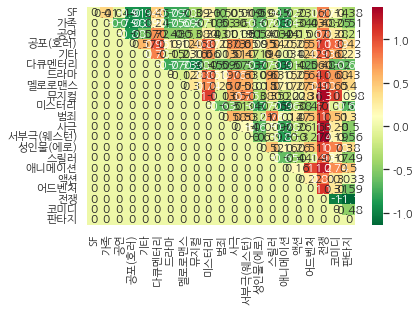

In [23]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 

plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

# 회고

- attribute 단어셋 생성 부분에서 중복 제거를 위해 set 메서드 사용
    - 결과를 확인해 본 결과 반절 정도는 대표성을 띄고
    - 나머지 반절 정도는 약간 이름? 같은 단어들이 선정되 대표성을 띄는지는 의문이 생김

- WEAT score를 통한 편향성 조사
    - 이 장르에서는 이게 맞다! 하는것이 반정도
    - 이 장르에서는 이게 맞나? 하는게 나머지 반정도
        - 대표성을 띄는 단어가 적절하지 않아서 그런가??

다음번에 이와 같은 편향성과 관련된 실험을 하게 된다면 중복을 제거하지 않거나, 중복 제거하는 방법을 다르게 해 성능을 높여보고 싶음

